// The Round Table
digraph {
	A [label="King Arthur"]
	B [label="Sir Bedevere the Wise"]
	L [label="Sir Lancelot the Brave"]
	A -> B
	A -> L
	B -> L [constraint=false]
}



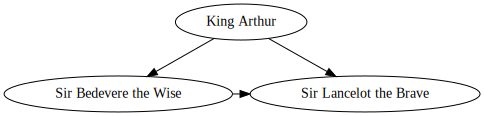

In [1]:
from graphviz import Digraph

dot = Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave') # add a node
dot.edges(['AB', 'AL']) # add edges
dot.edge('B', 'L', constraint='false') # add an edge with constraint

print(dot.source) # print the dot file

dot

### **Let's dive in!**
**Come up with a causal models and draw DAGs for the situations described below:**

1. Identify Key Variables: Start by listing the treatment, outcome, and any potential confounds.

2. Draw Arrows Carefully: Arrows represent causal relationships. Be explicit about the direction of causality.

3. Check for Confounding: Look for variables that influence both the treatment and the outcome.

4. Validate Assumptions: Ensure the DAG reflects realistic causal relationships in the problem domain.

5. Discuss the type of confounding (there may be more to it than "elemental confounds"!) and expected bias.

In [131]:
import re

EMPTY_RE = re.compile(r'^\s*$')
COMMENT_RE = re.compile(r'^\s*//.*$')
NODE_RE = re.compile(r'^\s*(\w+|"[^"]+")\s*(?:\[((?:[^,]+)(?:,(?:[^,]+))*)\])?\s*$')
NODE_ATTR_RE = re.compile(r'^(?:\s*(\w+|"[^"]+")\s*|\s*(\w+|"[^"]+")\s*=\s*(\w+|"[^"]+")\s*)$')
EDGE_RE = re.compile(r'^\s*(\w+|"[^"]+")\s*->\s*(\w+|"[^"]+")\s*$')

def node_to_dagitty(node_id, node_attrs, extra_attrs):
    node_label = node_attrs['label'] if 'label' in node_attrs else node_id
    if node_id in extra_attrs:
        return f'\t{node_label} [{extra_attrs[node_id]}]'
    return f'\t{node_label}'

def edge_to_dagitty(node_from, node_to, node_from_attrs, node_to_attrs):
    node_from_label = node_from_attrs['label'] if 'label' in node_from_attrs else node_from
    node_to_label = node_to_attrs['label'] if 'label' in node_to_attrs else node_to
    return f'\t{node_from_label} -> {node_to_label}'

def graphviz_to_dagitty(source, extra_attrs={}):
    source_lines = [line for line in source.split('\n') if not COMMENT_RE.match(line) and not EMPTY_RE.match(line)]

    assert source_lines[0] == 'digraph {'
    assert source_lines[-1] == '}'

    nodes = {}
    edges = []

    for line in source_lines[1:-1]:
        if l_m := NODE_RE.match(line):
            node_id = l_m.group(1)
            node_attrs = l_m.group(2)

            parsed_attrs = {}

            if node_attrs is not None:
                for attr in node_attrs.split(','):
                    a_m = NODE_ATTR_RE.match(attr)
                    match a_m.groups():
                        case (attr_id, None, None):
                            parsed_attrs[attr_id] = None
                        case (None, attr_id, attr_value):
                            parsed_attrs[attr_id] = attr_value
                        case _:
                            assert False, 'Invalid node attribute'

            nodes[node_id] = parsed_attrs
        elif l_m := EDGE_RE.match(line):
            node_from, node_to = l_m.group(1), l_m.group(2)
            if not node_from in nodes:
                nodes[node_from] = None
            if not node_to in nodes:
                nodes[node_to] = None
            edges.append((node_from, node_to))
        else:
            assert False, f'Invalid line: "{line}"'

    nodes_str = [node_to_dagitty(node_id, node_attrs, extra_attrs) for node_id, node_attrs in nodes.items()]
    edges_str = [edge_to_dagitty(node_from, node_to, nodes[node_from], nodes[node_to]) for node_from, node_to in edges]

    return '\n'.join(['dag {'] + nodes_str + edges_str + ['}'])

##### **Effect of a New Drug**
**Problem:** A new drug is being tested to reduce blood pressure. 

**Variables**: New Drug (yes/no), Blood pressure, Level of Exercise

dag {
	"New Drug (yes/no)" [exposure]
	"Blood pressure" [outcome]
	"Level of Exercise"
	"New Drug (yes/no)" -> "Blood pressure"
	"Level of Exercise" -> "Blood pressure"
}


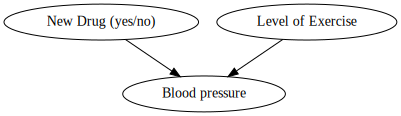

In [137]:
dot = Digraph(comment='New Drug')
dot.node('D', 'New Drug (yes/no)')
dot.node('B', 'Blood pressure')
dot.node('E', 'Level of Exercise')
dot.edges(['DB', 'EB'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'D': 'exposure', 'B': 'outcome'}))

# Do not stratify (i.e. don't include level of exercise)

dot

##### **Effect of a New Drug 2**
**Problem:** A new drug is tested to reduce blood pressure.

**Variables** New Drug, Blood pressure, Side effects, Staying in study

dag {
	"New Drug (yes/no)" [exposure]
	"Blood pressure" [outcome]
	"Side effects"
	"Staying in study"
	"New Drug (yes/no)" -> "Blood pressure"
	"New Drug (yes/no)" -> "Side effects"
	"Side effects" -> "Staying in study"
	"Blood pressure" -> "Staying in study"
}


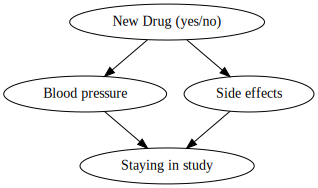

In [172]:
dot = Digraph(comment='New Drug')
dot.node('D', 'New Drug (yes/no)')
dot.node('B', 'Blood pressure')
dot.node('S', 'Side effects')
dot.node('L', 'Staying in study')
dot.edges(['DB', 'DS', 'SL', 'BL'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'D': 'exposure', 'B': 'outcome'}))

# Do not stratify

dot

##### **Effect of Tutoring on Test Scores**
**Problem**: A school introduces a tutoring program to improve students' math test scores. 

**Variables**: Tutoring, Math test scores, Parental support

dag {
	Tutoring [exposure]
	"Math test score" [outcome]
	"Parental support"
	Tutoring -> "Math test score"
	"Parental support" -> "Math test score"
	"Parental support" -> Tutoring
}


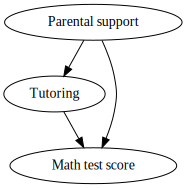

In [140]:
dot = Digraph(comment='New Drug')
dot.node('T', 'Tutoring')
dot.node('M', 'Math test score')
dot.node('P', 'Parental support')
dot.edges(['TM', 'PM', 'PT'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'T': 'exposure', 'M': 'outcome'}))

# Stratify on parental support

dot

##### **Effect of Tutoring on Test Scores 2**
**Problem**: A tutoring program is offered to students who score below a certain threshold on a pre-test. 

**Variables**: Pre-test score, Post-test score, Tutoring, Test anxiety

dag {
	Tutoring [exposure]
	"Pre-test score"
	"Post-test score" [outcome]
	"Test anxiety"
	"Pre-test score" -> Tutoring
	Tutoring -> "Post-test score"
	"Test anxiety" -> "Pre-test score"
	"Test anxiety" -> "Post-test score"
}


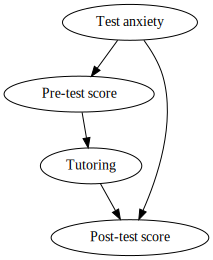

In [146]:
dot = Digraph(comment='New Drug')
dot.node('T', 'Tutoring')
dot.node('R', 'Pre-test score')
dot.node('O', 'Post-test score')
dot.node('A', 'Test anxiety')
dot.edges(['RT', 'TO', 'AR', 'AO'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'T': 'exposure', 'O': 'outcome'}))

# Startify by pre-test score or test anxiety

dot

#### **Effect of Education on Income**
**Problem:** Researchers want to estimate the effect of higher education on income.

**Variables:** Education, social networks, and income

dag {
	Education [exposure]
	"Social networks"
	Income [outcome]
	Education -> Income
	"Social networks" -> Income
	"Social networks" -> Education
}


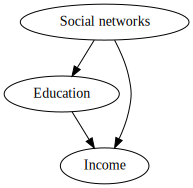

In [147]:
dot = Digraph(comment='New Drug')
dot.node('E', 'Education')
dot.node('S', 'Social networks')
dot.node('I', 'Income')
dot.edges(['EI', 'SI', 'SE'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'E': 'exposure', 'I': 'outcome'}))

# Stratify by social networks

dot

##### **Effect of Social Media on Mental Health**
**Problem**: A study investigates whether social media use causes depression. 

**Variables**: Social media use, screen time, sleep quality, mental health.

dag {
	"Social median use" [exposure]
	"Screen time"
	"Sleep quality"
	"Mental health" [outcome]
	"Social median use" -> "Screen time"
	"Screen time" -> "Sleep quality"
	"Social median use" -> "Mental health"
	"Sleep quality" -> "Mental health"
}


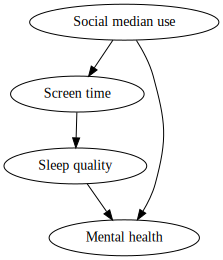

In [155]:
dot = Digraph(comment='New Drug')
dot.node('M', 'Social median use')
dot.node('S', 'Screen time')
dot.node('Z', 'Sleep quality')
dot.node('H', 'Mental health')
dot.edges(['MS', 'SZ', 'MH', 'ZH'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'M': 'exposure', 'H': 'outcome'}))

# For total effect no stratification, for direct effect stratify on screen time or sleep quality

dot

##### **Environment: Effect of Pollution on Health**
**Problem**: Researchers want to estimate the effect of long-term air pollution exposure on respiratory health. 

**Variables**: Pollution level, Respiratory health, Duration lived in same place

dag {
	"Pollution level" [exposure]
	"Respiratory health" [outcome]
	"Duration lived in same place"
	"Pollution level" -> "Respiratory health"
	"Pollution level" -> "Duration lived in same place"
}


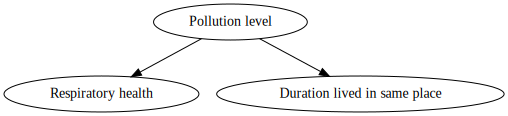

In [158]:
dot = Digraph(comment='New Drug')
dot.node('P', 'Pollution level')
dot.node('H', 'Respiratory health')
dot.node('D', 'Duration lived in same place')
dot.edges(['PH', 'PD'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'P': 'exposure', 'H': 'outcome'}))

# No stratification needed (do not include duration lived in same place)

dot

##### **Effect of Solar Panels on Electricity Bills**
**Problem**: A study investigates the effect of installing solar panels on household electricity bills.

**Variables**: Solar panels, eco-consciousness, electricity bills

dag {
	"Solar panels" [exposure]
	"Eco-conciousness"
	"Electricity bills" [outcome]
	"Eco-conciousness" -> "Solar panels"
	"Solar panels" -> "Electricity bills"
	"Eco-conciousness" -> "Electricity bills"
}


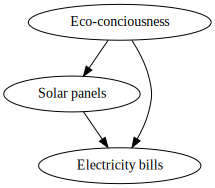

In [160]:
dot = Digraph(comment='New Drug')
dot.node('P', 'Solar panels')
dot.node('E', 'Eco-conciousness')
dot.node('B', 'Electricity bills')
dot.edges(['EP', 'PB', 'EB'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'P': 'exposure', 'B': 'outcome'}))

# Stratify on eco-counciousness

dot

##### **Effect of a Job Training Program**
**Problem**: A job training program is offered to unemployed individuals, specifically targeting older participants.

**Variables**: Enrollment (yes/no), age, Employment status in 1 year

dag {
	"Training (yes/no)" [exposure]
	Age
	"Employment status in 1 year" [outcome]
	"Training (yes/no)" -> "Employment status in 1 year"
	Age -> "Training (yes/no)"
	Age -> "Employment status in 1 year"
}


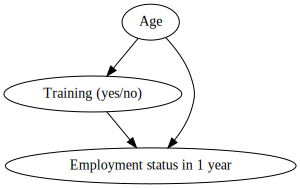

In [163]:
dot = Digraph(comment='New Drug')
dot.node('T', 'Training (yes/no)')
dot.node('A', 'Age')
dot.node('E', 'Employment status in 1 year')
dot.edges(['TE', 'AT', 'AE'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'T': 'exposure', 'E': 'outcome'}))

# Stratify on age

dot

##### **Effect of Fertilizer on Crop Yield**
**Problem**: A study investigates the effect of fertilizer on crop yield.

**Variables**: Fertilizer, Crop yield, Soil quality


dag {
	Fertilizer [exposure]
	"Crop yield" [outcome]
	"Soil quality"
	Fertilizer -> "Soil quality"
	"Soil quality" -> "Crop yield"
	Fertilizer -> "Crop yield"
}


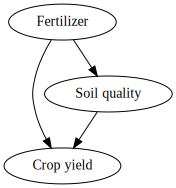

In [164]:
dot = Digraph(comment='New Drug')
dot.node('F', 'Fertilizer')
dot.node('Y', 'Crop yield')
dot.node('S', 'Soil quality')
dot.edges(['FS', 'SY', 'FY'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'F': 'exposure', 'Y': 'outcome'}))

# Don't stratify for total effect, startify on soil quality for direct effect

dot

##### **Effect of Sleep on Academic Performance**
**Problem**: Researchers want to estimate the effect of sleep duration on academic performance. 

**Variable**: Sleep duration (self-report), academic performance, stress levels

dag {
	"Sleep duration (self-report)" [exposure]
	"Academic performance" [outcome]
	"Stress levels"
	"Stress levels" -> "Academic performance"
	"Sleep duration (self-report)" -> "Academic performance"
	"Stress levels" -> "Sleep duration (self-report)"
}


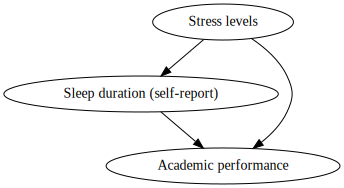

In [165]:
dot = Digraph(comment='New Drug')
dot.node('D', 'Sleep duration (self-report)')
dot.node('P', 'Academic performance')
dot.node('S', 'Stress levels')
dot.edges(['SP', 'DP', 'SD'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'D': 'exposure', 'P': 'outcome'}))

# Stratify on stress levels

dot

##### **Effect of Police Presence on Crime Rates**
**Problem**: A city increases police presence in high-crime neighborhoods to reduce crime. 

**Variables**: Police presence, Crime level


dag {
	"Police presence" [exposure]
	"Crime level" [outcome]
	Neighborhood
	Neighborhood -> "Crime level"
	"Police presence" -> "Crime level"
	Neighborhood -> "Police presence"
}


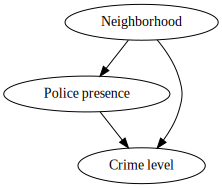

In [166]:
dot = Digraph(comment='New Drug')
dot.node('P', 'Police presence')
dot.node('C', 'Crime level')
dot.node('N', 'Neighborhood')
dot.edges(['NC', 'PC', 'NP'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'P': 'exposure', 'C': 'outcome'}))

# Stratify on neighborhood

dot

##### **Effect of Marriage on Happiness**
**Problem**: A study investigates whether marriage increases happiness. 

**Variables**: happiness, marriage status, pre-marriage happiness

dag {
	Happiness [outcome]
	"Marriage status" [exposure]
	"Pre-marriage happiness"
	"Pre-marriage happiness" -> "Marriage status"
	"Pre-marriage happiness" -> Happiness
	"Marriage status" -> Happiness
}


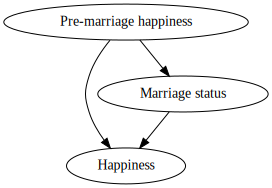

In [167]:
dot = Digraph(comment='New Drug')
dot.node('H', 'Happiness')
dot.node('M', 'Marriage status')
dot.node('P', 'Pre-marriage happiness')
dot.edges(['PM', 'PH', 'MH'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'M': 'exposure', 'H': 'outcome'}))

# Stratify on pre-marriage happiness

dot

##### **Effect of Vaccination on Disease Spread**
**Problem**: Researchers want to estimate the effect of vaccination on disease spread. 

**Variables**: Vaccination status, Disease status, Average vaccination rate in community

dag {
	"Vaccination status" [exposure]
	"Disease status" [outcome]
	"Average vaccination rate in community"
	"Vaccination status" -> "Disease status"
	"Vaccination status" -> "Average vaccination rate in community"
	"Average vaccination rate in community" -> "Disease status"
}


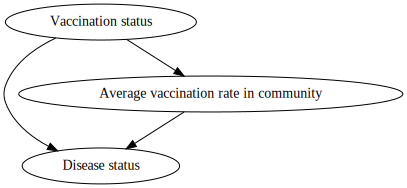

In [170]:
dot = Digraph(comment='New Drug')
dot.node('V', 'Vaccination status')
dot.node('D', 'Disease status')
dot.node('C', 'Average vaccination rate in community')
dot.edges(['VD', 'VC', 'CD'])

print(graphviz_to_dagitty(dot.source, extra_attrs={'V': 'exposure', 'D': 'outcome'}))

# No stratification for total effect, stratify on average vacciation rate for direct effect

dot